In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2,f_classif
from sklearn.tree import DecisionTreeClassifier,export_graphviz

In [2]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

seed = 999

##Load Dataset

In [3]:
test_data = pd.read_csv('C:/Users/siyue/OneDrive/Desktop/Machine Learning/Data/Pricing_Test/test_results.csv', 
                   parse_dates=['timestamp'], index_col="user_id")

test_data.head()

,timestamp,source,device,operative_system,test,price,converted
user_id,,,,,,,
604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [4]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316800 entries, 604839 to 832372
Data columns (total 7 columns):
timestamp           316800 non-null object
source              316800 non-null object
device              316800 non-null object
operative_system    316800 non-null object
test                316800 non-null int64
price               316800 non-null int64
converted           316800 non-null int64
dtypes: int64(3), object(4)
memory usage: 19.3+ MB


In [5]:
test_data.isnull().sum()

timestamp           0
source              0
device              0
operative_system    0
test                0
price               0
converted           0
dtype: int64

##Data Processing and Cleaning

In [6]:
# Problem with the data: test and price not match
test_data[['price', 'test','converted']].groupby(['test', 'price']).count()

converted
test price           
0    39        202517
     59           210
1    39           155
     59        113918

It seems that there are some problems with the data:

1. there are a small amount of users who are labelled with test=0 but actually see price $59.
2. there are a small amount of users who are labelled with test=1 but actually see price $39.

Fortunately, they are only a very small portion of the whole dataset. The first step is to remove these problematic inputs.

In [7]:
# Only keep the valid data.
test_data = test_data[((test_data['test'] == 0) & (test_data['price'] == 39)) | 
                      ((test_data['test'] == 1) & (test_data['price'] == 59))]

In [8]:
# create new column called `revenue`
test_data['revenue'] = test_data['converted'] * test_data['price']

test_data.head()

,timestamp,source,device,operative_system,test,price,converted,revenue
user_id,,,,,,,,
604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,0
624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,0
317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,0
685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,0
820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,0


In [9]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316435 entries, 604839 to 832372
Data columns (total 8 columns):
timestamp           316435 non-null object
source              316435 non-null object
device              316435 non-null object
operative_system    316435 non-null object
test                316435 non-null int64
price               316435 non-null int64
converted           316435 non-null int64
revenue             316435 non-null int64
dtypes: int64(4), object(4)
memory usage: 21.7+ MB


##Check whether test and control group are randomly splitted?

Now, let's check whether or not the test are totally randomized through simple visualization.

In [10]:
X = test_data.copy()
del X['timestamp']

# to use sklearn to check feature importance, we must convert string values to numbers
src_label_encoder = LabelEncoder()
dev_label_encoder = LabelEncoder()
os_label_encoder = LabelEncoder()

X["source"] = src_label_encoder.fit_transform(test_data.source)
X["device"] = dev_label_encoder.fit_transform(test_data.device)
X["OS"] = os_label_encoder.fit_transform(test_data.operative_system)

In [11]:
X.head()

,source,device,operative_system,test,price,converted,revenue,OS
user_id,,,,,,,,
604839,3,0,iOS,0,39,0,0,1
624057,8,0,android,0,39,0,0,0
317970,0,0,android,0,39,0,0,0
685636,5,0,iOS,1,59,0,0,1
820854,3,1,mac,0,39,0,0,3


Run chi-square test to see which factor impacts the spliting between test and control group.

In [12]:
colnames = ["source","device","OS"]
ch2values,pvalues = chi2(X.loc[:,colnames],X["test"])
pd.DataFrame({'chi2_value':ch2values,'pvalue':pvalues},index = colnames).sort_values(by='pvalue')

,chi2_value,pvalue
OS,83.937937,5.105534e-20
device,44.785346,2.198620e-11
source,0.918060,3.379849e-01


From result above, we can see that test and control group are not randomly splitted. OS and device have great impact on the splitting.

In [13]:
def calc_ratios(s):
    d = s.value_counts(normalize=True)
    d['total'] = s.shape[0]
    return d
test_ctrl_by_os = test_data.groupby('operative_system')['test'].apply(calc_ratios).unstack()
test_ctrl_by_os

,0,1,total
operative_system,,,
android,0.643475,0.356525,74870.0
iOS,0.648045,0.351955,95353.0
linux,0.533656,0.466344,4130.0
mac,0.652365,0.347635,25055.0
other,0.647895,0.352105,16177.0
windows,0.629817,0.370183,100850.0


The experiment claim that '66% of the users have seen the old price (39), while a random sample of 33% users a higher price (59).', but users from Linux don't obey such rule, but 53% go to control group, 47% go to test group.

###Visualization of OS

In [14]:
# Check proportion of each kind of OS
os_by_test_ctrl = test_data.groupby('test')['operative_system'].apply(lambda s: s.value_counts(normalize=True)).unstack()
os_by_test_ctrl

,windows,iOS,android,mac,other,linux
test,,,,,,
0,0.313638,0.305125,0.237891,0.080709,0.051754,0.010883
1,0.327718,0.294598,0.234318,0.076459,0.050001,0.016907


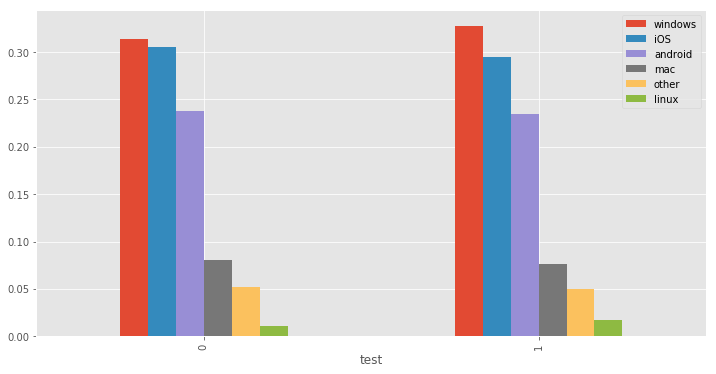

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))
os_by_test_ctrl.plot(kind='bar', ax=ax)
plt.show()

C:\Users\siyue\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


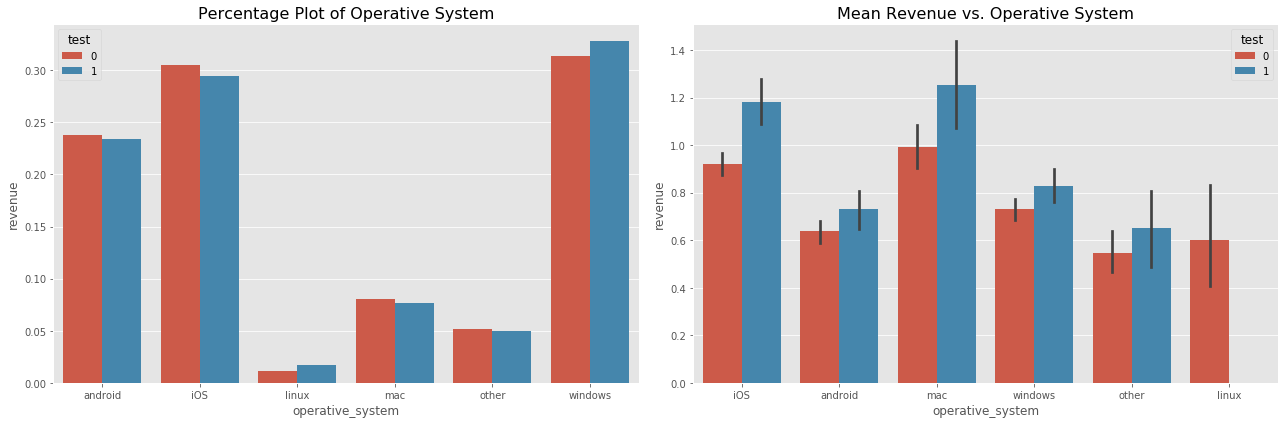

In [16]:
count = test_data[['operative_system', 'test', 'revenue']].groupby(['operative_system', 'test']).count().reset_index()
count.loc[count['test'] == 1, 'revenue'] = count.loc[count['test'] == 1, 'revenue'] / 113918
count.loc[count['test'] == 0, 'revenue'] = count.loc[count['test'] == 0, 'revenue'] / 202517

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.barplot(x='operative_system', y='revenue', hue='test', data=count, ax=ax[0])
ax[0].set_title('Percentage Plot of Operative System', fontsize=16)

sns.barplot(x='operative_system', y='revenue', hue='test', data=test_data, ax=ax[1])
ax[1].set_title('Mean Revenue vs. Operative System', fontsize=16)
plt.tight_layout()
plt.show()

###Visualization of Device

In [17]:
# Check randominess
device_by_test_ctrl = test_data.groupby('test')['device'].apply(lambda x: x.value_counts(normalize=True)).unstack()
device_by_test_ctrl

,mobile,web
test,,
0,0.594365,0.405635
1,0.578469,0.421531


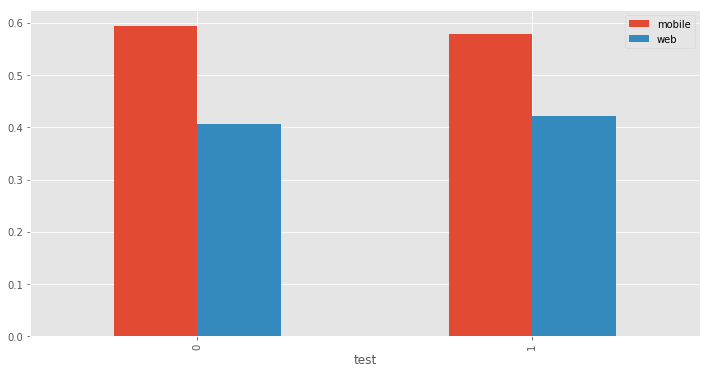

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))
device_by_test_ctrl.plot(kind='bar', ax=ax)
plt.show()

C:\Users\siyue\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


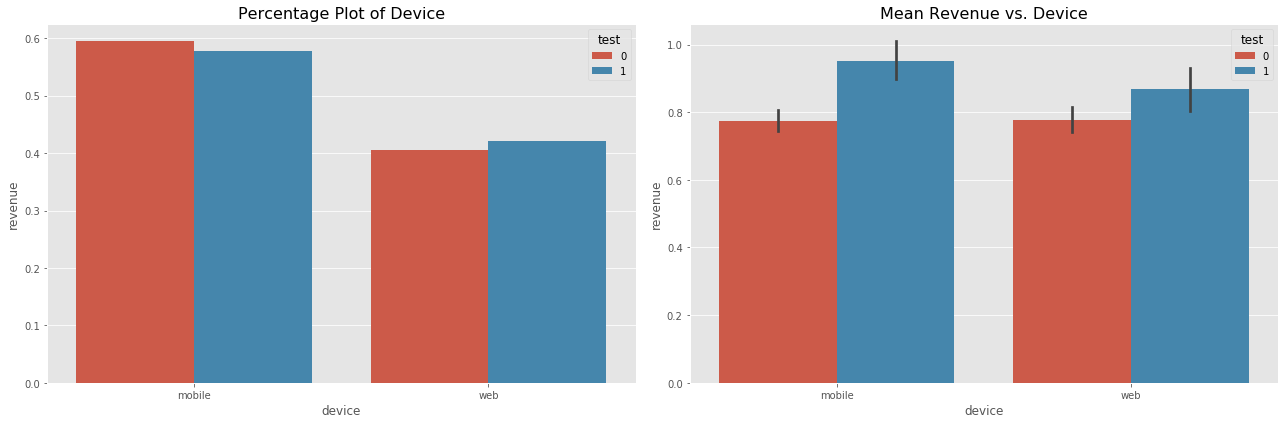

In [19]:
count = test_data[['device', 'test', 'revenue']].groupby(['device', 'test']).count().reset_index()
count.loc[count['test'] == 1, 'revenue'] = count.loc[count['test'] == 1, 'revenue'] / 113918
count.loc[count['test'] == 0, 'revenue'] = count.loc[count['test'] == 0, 'revenue'] / 202517

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.barplot(x='device', y='revenue', hue='test', data=count, ax=ax[0])
ax[0].set_title('Percentage Plot of Device', fontsize=16)

sns.barplot(x='device', y='revenue', hue='test', data=test_data, ax=ax[1])
ax[1].set_title('Mean Revenue vs. Device', fontsize=16)
plt.tight_layout()
plt.show()

We can see that OS distribution in test/control groups are very different. As I said before, test and control group are not randomly splitted.

##Question 1
Should the company sell its software for 39 or 59?

In [20]:
# check the conversion rate for A/B test
test_data[['test', 'converted']].groupby('test').mean()

,converted
test,
0,0.019900
1,0.015555


In [21]:
# check the revenue for A/B test
test_data[['test', 'revenue']].groupby('test').mean()

,revenue
test,
0,0.776083
1,0.917748


we are going to perform a t-test to test whether the test group's average revenue is higher than control group's average revenue

H0: experimental group's average revenue is equal to or less than control group's average revenue
HA: test group's average revenue is higher than control group's average revenue

In [22]:
ctr_val = test_data[test_data['test'] == 0]['revenue'].values
exp_val = test_data[test_data['test'] == 1]['revenue'].values
print(ss.ttest_ind(ctr_val, exp_val, axis=0, equal_var=False))

Ttest_indResult(statistic=-5.715224666463108, pvalue=1.0972577312420781e-08)


The above test is actually two tailed test. What we want is one-tailed test. However, from above result, we can easily conclude that even for one-tailed test, we can safely conclude that we can reject the null hypothesis, and conclude that experimental group's average revenue is higher than control group's average revenue.

However, due to OS distribution are not the same between test and control group, price the only difference between test/control groups, so we cannot contribute the increase in average revenue to price.

The experiment design fails, I cannot answer decide whether we can sell software to all users in 59 dollars. I suggest

1. Find the reason why linux users have different representation ratio than other OS.
2. Then run the experiment again, make sure price is the only difference between test and control group
3. Then run t-test again, to see whether the average revenue is significantly improved.
4. Then I can draw the conclusion.

##Question 2
The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are the main ﬁndings looking at the data?

In [23]:
# X is the data after being transformed by LabelEncoder
X.tail()# glance the data

,source,device,operative_system,test,price,converted,revenue,OS
user_id,,,,,,,,
17427,3,1,windows,0,39,0,0,5
687787,5,1,windows,0,39,0,0,5
618863,1,1,mac,0,39,0,0,3
154636,6,0,android,0,39,0,0,0
832372,3,0,android,1,59,0,0,0


####Chi-Square test
I first run Chi-Square test to see which feature greatly impact converted or not

In [24]:
colnames = ["source","device","OS",'price']
ch2values,pvalues = chi2(X.loc[:,colnames],X["converted"])
pd.DataFrame({'chi2_value':ch2values,'pvalue':pvalues},index = colnames).sort_values(by='pvalue')

,chi2_value,pvalue
price,152.509801,4.902372e-35
OS,7.378510,6.600782e-03
source,2.451427,1.174181e-01
device,0.706940,4.004615e-01


Chi-Square test tells us,

1. Price and OS are two main factor which impact converted or not.
2. Source and Device don't impact conversion rate that much.

####How price affects conversion?

In [25]:
converted_by_price= test_data.groupby("price")['converted'].apply(lambda s: s.value_counts(normalize=True)).unstack()
converted_by_price

,0,1
price,,
39,0.980100,0.019900
59,0.984445,0.015555


Users getting $59 have lower conversion rate than users getting $39.

####How OS affects conversions?

In [26]:
converted_by_OS= test_data.groupby("operative_system")['converted'].apply(lambda s: s.value_counts(normalize=True)).unstack()
converted_by_OS

,0,1
operative_system,,
android,0.985081,0.014919
iOS,0.977672,0.022328
linux,0.991768,0.008232
mac,0.976013,0.023987
other,0.987019,0.012981
windows,0.983034,0.016966


C:\Users\siyue\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


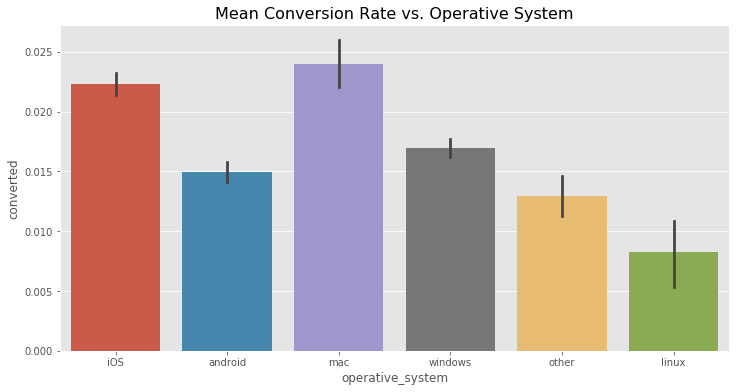

In [27]:
# Visualization of operative system
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='operative_system', y='converted', data=test_data, ax=ax)
ax.set_title('Mean Conversion Rate vs. Operative System', fontsize=16)
plt.show()

Rrom above result, we can see:

1. Mac and iOS users have higher conversion rate than users from other OS.
2. Linux users have lower conversion rate than users from other OS.

###Model by Decision Tree

I will build a Decision Tree to get feature importance. Since the question is asking about "actionable insight" other than a model which precisely predict converted or not, so I will just fit a shallow Decision Tree on all the data, without giving out model's performance on test set.

In [28]:
test_data.sample(10)# glance the data

,timestamp,source,device,operative_system,test,price,converted,revenue
user_id,,,,,,,,
717241,2015-03-13 11:21:08,ads-google,mobile,android,1,59,0,0
878089,2015-05-08 10:16:16,seo-yahoo,mobile,iOS,0,39,0,0
7047,2015-05-11 10:35:02,ads-google,mobile,android,0,39,0,0
350419,2015-03-05 06:36:04,direct_traffic,mobile,android,1,59,0,0
189536,2015-05-07 05:09:50,seo-google,web,windows,1,59,0,0
199697,2015-03-13 06:39:42,ads_facebook,mobile,iOS,0,39,0,0
293811,2015-05-08 12:28:16,direct_traffic,mobile,iOS,0,39,0,0
845650,2015-03-20 09:45:04,ads_facebook,mobile,android,1,59,0,0
783234,2015-05-29 07:29:16,ads-google,web,windows,0,39,0,0


In [29]:
X = test_data.copy()
del X['timestamp']
del X['test']
del X['revenue']

In [30]:
X.source.value_counts()

direct_traffic     60272
ads-google         59342
ads_facebook       53355
ads_other          29826
seo-google         23148
ads-bing           22831
seo_facebook       21183
friend_referral    20678
seo-other           9244
ads-yahoo           7571
seo-yahoo           6841
seo-bing            2144
Name: source, dtype: int64

In [31]:
X.device.value_counts()

mobile    186267
web       130168
Name: device, dtype: int64

In [32]:
X.operative_system.value_counts()

windows    100850
iOS         95353
android     74870
mac         25055
other       16177
linux        4130
Name: operative_system, dtype: int64

In [33]:
# One-Hot-Encoding on categorical features
X = pd.get_dummies(X, drop_first=False)

# a categorical feature of K unique values, only need K-1 vectors
# I don't use 'drop_first' parameter in get_dummies, since it cannot specify which level to drop
del X['source_ads_other']
del X['device_web']
del X['operative_system_other']

In [34]:
X.tail()# glance the data

,price,converted,source_ads-bing,source_ads-google,source_ads-yahoo,source_ads_facebook,source_direct_traffic,source_friend_referral,source_seo-bing,source_seo-google,source_seo-other,source_seo-yahoo,source_seo_facebook,device_mobile,operative_system_android,operative_system_iOS,operative_system_linux,operative_system_mac,operative_system_windows
user_id,,,,,,,,,,,,,,,,,,,
17427,39,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
687787,39,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
618863,39,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
154636,39,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0
832372,59,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0


In [35]:
Xtrain = X.loc[:,X.columns != 'converted']
ytrain = X.loc[:,'converted']

In [36]:
Xtrain.head()# glance the data

,price,source_ads-bing,source_ads-google,source_ads-yahoo,source_ads_facebook,source_direct_traffic,source_friend_referral,source_seo-bing,source_seo-google,source_seo-other,source_seo-yahoo,source_seo_facebook,device_mobile,operative_system_android,operative_system_iOS,operative_system_linux,operative_system_mac,operative_system_windows
user_id,,,,,,,,,,,,,,,,,,
604839,39,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0
624057,39,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0
317970,39,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
685636,59,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0
820854,39,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


In [37]:
import graphviz
from IPython.display import Image
from os import system
from sklearn import tree

In [38]:
dt = DecisionTreeClassifier(max_depth=4)
dt.fit(Xtrain,ytrain)
tree.export_graphviz(dt,feature_names=Xtrain.columns,proportion=True,leaves_parallel=True, filled=True)

'digraph Tree {\nnode [shape=box, style="filled", color="black"] ;\ngraph [ranksep=equally, splines=polyline] ;\n0 [label="source_friend_referral <= 0.5\\ngini = 0.036\\nsamples = 100.0%\\nvalue = [0.982, 0.018]", fillcolor="#e58139fa"] ;\n1 [label="operative_system_iOS <= 0.5\\ngini = 0.033\\nsamples = 93.5%\\nvalue = [0.983, 0.017]", fillcolor="#e58139fb"] ;\n0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;\n2 [label="operative_system_mac <= 0.5\\ngini = 0.03\\nsamples = 65.3%\\nvalue = [0.985, 0.015]", fillcolor="#e58139fb"] ;\n1 -> 2 ;\n3 [label="source_direct_traffic <= 0.5\\ngini = 0.028\\nsamples = 58.0%\\nvalue = [0.986, 0.014]", fillcolor="#e58139fb"] ;\n2 -> 3 ;\n4 [label="gini = 0.03\\nsamples = 46.1%\\nvalue = [0.985, 0.015]", fillcolor="#e58139fb"] ;\n3 -> 4 ;\n5 [label="gini = 0.019\\nsamples = 11.9%\\nvalue = [0.99, 0.01]", fillcolor="#e58139fc"] ;\n3 -> 5 ;\n6 [label="source_ads-bing <= 0.5\\ngini = 0.044\\nsamples = 7.4%\\nvalue = [0.977, 0.023]", fillcolo

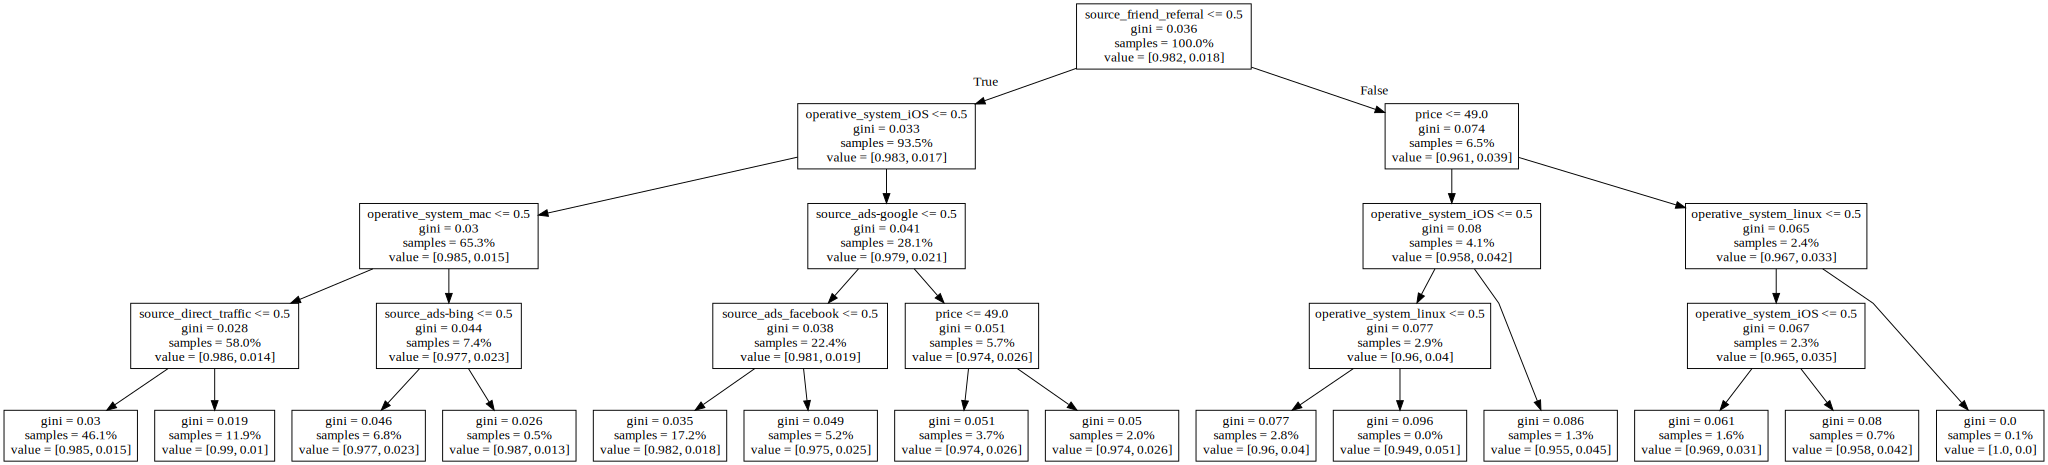

In [41]:
dot_data = tree.export_graphviz(dt,feature_names=Xtrain.columns,proportion=True,leaves_parallel=True)  
graph = graphviz.Source(dot_data)
graph

From above tree plot, we can see that, to reach the leaf node with highest conversion rate (the third leaf from right with conversion rate=0.05), the path is:

1. source 'friend_referral' = true
2. price < 49, i.e., price = 39
3. OS 'iOS'= true


In [40]:
pd.Series(dt.feature_importances_,index = Xtrain.columns).sort_values(ascending=False)

source_friend_referral      0.581165
operative_system_iOS        0.136965
operative_system_mac        0.093429
source_direct_traffic       0.059473
source_ads_facebook         0.041326
source_ads-google           0.038754
price                       0.020501
operative_system_linux      0.017944
source_ads-bing             0.010442
source_ads-yahoo            0.000000
operative_system_windows    0.000000
source_seo-bing             0.000000
source_seo-other            0.000000
source_seo-yahoo            0.000000
source_seo_facebook         0.000000
device_mobile               0.000000
operative_system_android    0.000000
source_seo-google           0.000000
dtype: float64

Actionable Insights:

1. friend_referral, Apple user (MAC or iOS), low price are three great positive factors which improve the conversion rate
2. if we want to increase the price, which impacts negatively on conversion rate, we must compensate on the other two factors
3. lauch special marketing program targeted to Apple users (MAC or iOS users)
4. run some program which rewards user which can invite his/her friend to use our software
5. Linux users don't like our software as much as users on other OS. Development team should find out the reason. For example, is there any incompatibility issue on Linux?